In [1]:
from sample_psrs import load_psrs, fake_model_2a
from model import PulsarLogLikelihood
from autograd import grad
from fast_model import FastLogLikelihood

import numpy as np


from enterprise.signals import utils
%load_ext autoreload
%autoreload 2

In [2]:
psrs = load_psrs(1e-15, 1)
pta = fake_model_2a(psrs)

In [7]:
from pta_fast_model import FastLogLikelihood

In [8]:
lnlikelihood = FastLogLikelihood(pta, psrs)

In [9]:
%%timeit
lnlikelihood([0, -20, 0, -20, -20])

260 µs ± 8.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%%timeit
pta.get_lnlikelihood([0, -20, 0, -20, -20])

2.07 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import matplotlib.pyplot as plt

In [148]:
# sample the old way of doing things:
ndim = 5
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = './chains/true_data'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, outDir=outDir, resume=True)

N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [147]:
# sample the new way of doing things
ndim = 5
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = './chains/fast_data'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, outDir=outDir, resume=True)

N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

TypeError: sample() got an unexpected keyword argument 'resume'

In [132]:
# load in chains
with open('./chains/true_data/chain_1.txt', 'r') as f:
    data0 = np.loadtxt(f)
with open('./chains/fast_data/chain_1.txt', 'r') as f:
    data1 = np.loadtxt(f)

In [144]:
burn = int(0.25 * data0.shape[0])
print(burn)

2475


In [145]:
gw_idx = list(pta.param_names).index('log10_A_gw')

4

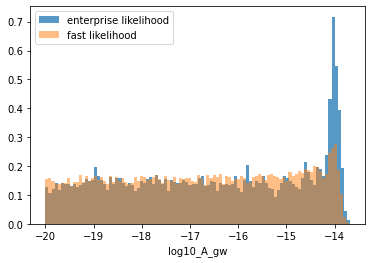

In [146]:
for ii in range(5):
    plt.hist(data0[burn:, ii], bins=100, density=True, alpha=0.75, label='enterprise likelihood')
    plt.hist(data1[burn:, ii], bins=100, density=True, alpha=0.5, label='fast likelihood')
    plt.xlabel('log10_A_gw')
    plt.legend()
    plt.savefig('test.png')
    plt.show()